Imports, loading data set, visualising data set, and setting up for analysis.

In [41]:
import os
import glob
import re
import wfdb as wf
from wfdb import processing
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from scipy.signal import butter, lfilter
from scipy.signal import argrelextrema

samplenumber=50000    #sample size for analysis

filenames = glob.glob('DataFiles/*.dat') #reading files from DataFiles folder
pchannel=[] #initiating arrays
file_nums=[]
pfreq=[]
recordall=[]
annall=[]

for i, s in enumerate(filenames):                 
    num_str = re.search("(\d+).dat",  filenames[i]) 
    file_nums.append(num_str.group(1)) #extracting the numbering system of the data files, saving them to an array for calling them in the future 
    
for j, k in enumerate(file_nums):
    record = wf.rdrecord('Datafiles/'+file_nums[j], sampto=samplenumber)
    pchannel.append(record.p_signal[:,0])
    recordall.append(record)
    ann = wf.rdann('DataFiles/'+file_nums[j], 'atr', sampto=samplenumber) #reading the data and annotation files
    annall.append(ann)
    #wf.plot_wfdb(record=record, annotation = ann, title='Record '+file_nums[j]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,10)) #plotting all of the files

Finding Peaks through wfdb.

Gqrs detected peak indices: [250, 472, 614, 867, 1081, 1298, 1586, 1818, 2029, 2249, 2508, 2749, 2987, 3246, 3464, 3674, 3914, 4151, 4381, 4595, 4825, 5124, 5362, 5631, 5828, 6092, 6363, 6596, 6740, 6947, 7186, 7414, 7617, 7842, 8193, 8399, 8668, 8876, 9103, 9416, 9677, 9899, 10248, 10498, 10749, 10952, 11152, 11427, 11670, 11923, 12167, 12376, 12586, 12789, 13016, 13201, 13452, 13723, 13977, 14197, 14450, 14667, 14953, 15185, 15413, 15642, 15874, 16125, 16351, 16606, 16845, 16996, 17259, 17521, 17786, 18053, 18258, 18513, 18747, 18977, 19168, 19355, 19555, 19767, 20033, 20274, 20511, 20692, 21047, 21246, 21444, 21638, 21840, 22083, 22356, 22618, 22876, 23184, 23438, 23691, 23938, 24193, 24431, 24700, 24967, 25193, 25390, 25518, 25846, 26103, 26309, 26515, 26780, 27111, 27365, 27580, 27826, 28098, 28332, 28619, 28886, 29135, 29413, 29661, 29909, 30204, 30448, 30683, 30955, 31150, 31424, 31636, 31916, 32151, 32340, 32552, 32805, 33083, 33337, 33605, 33870, 34130, 34379, 34606, 34800, 35

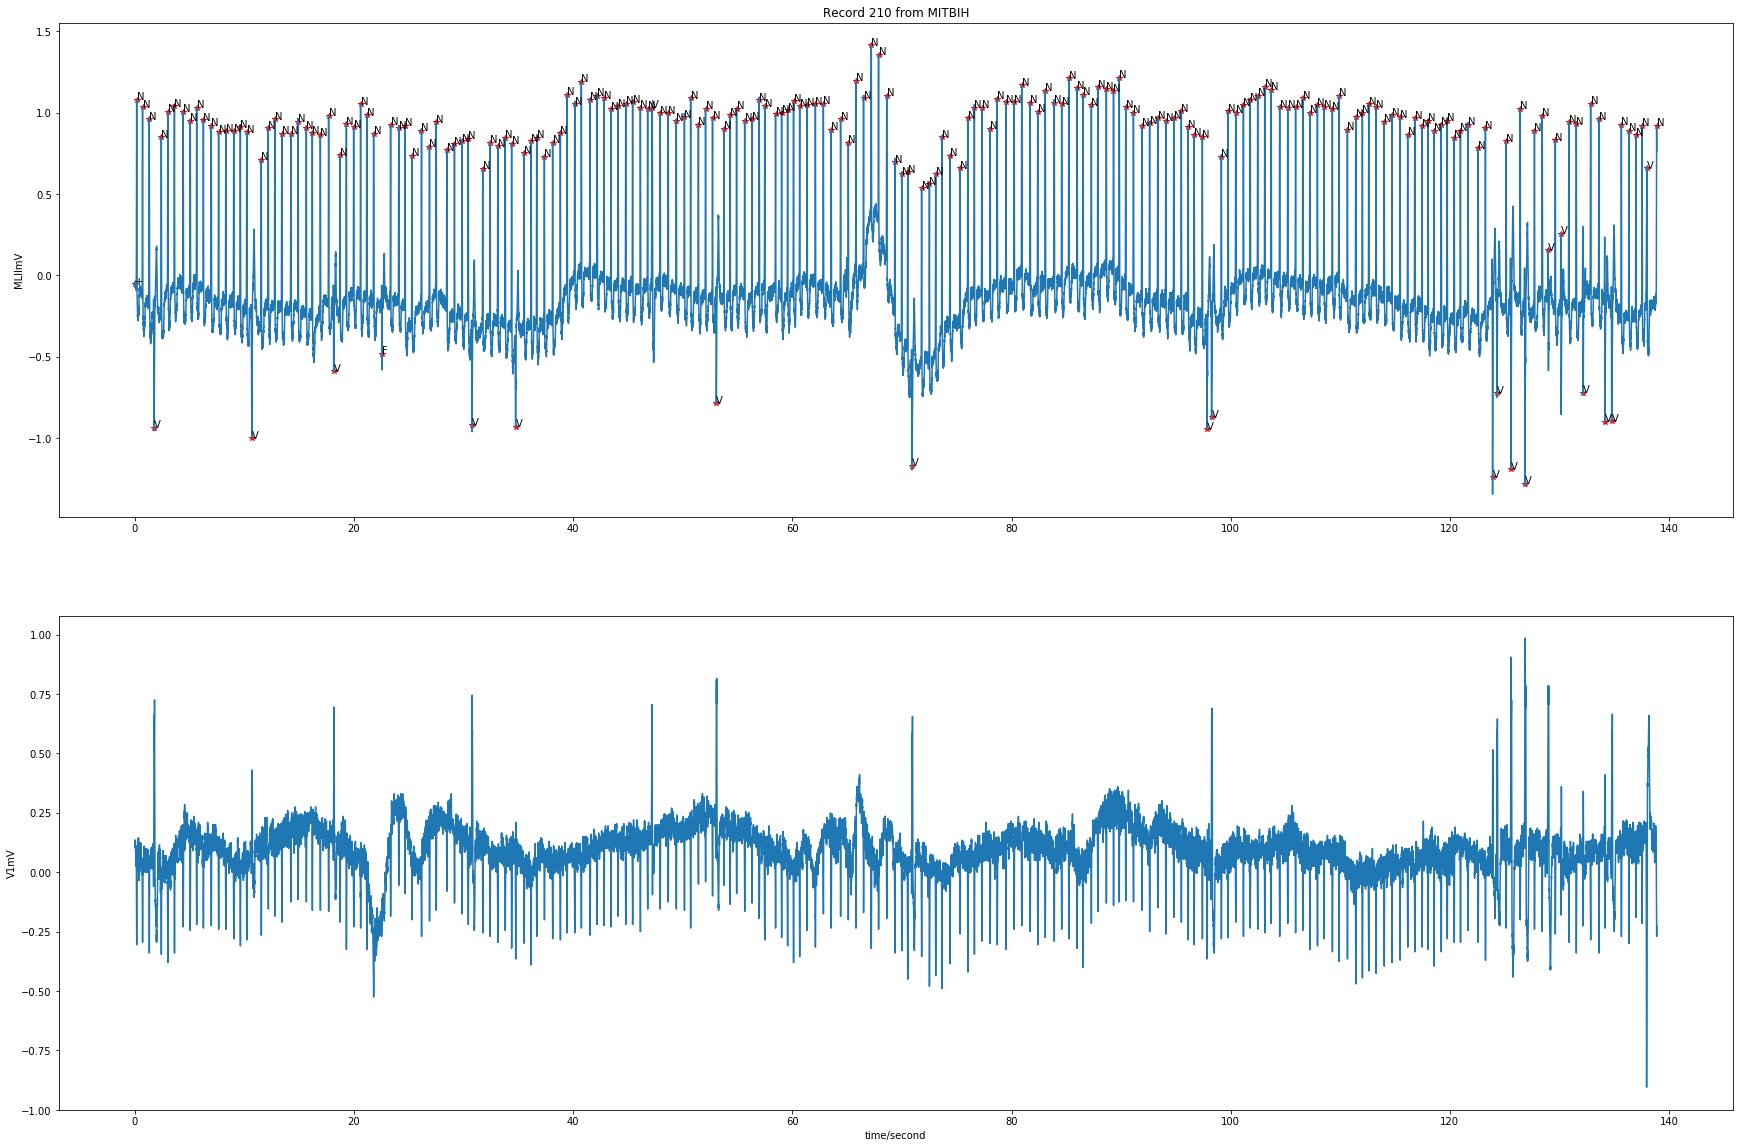

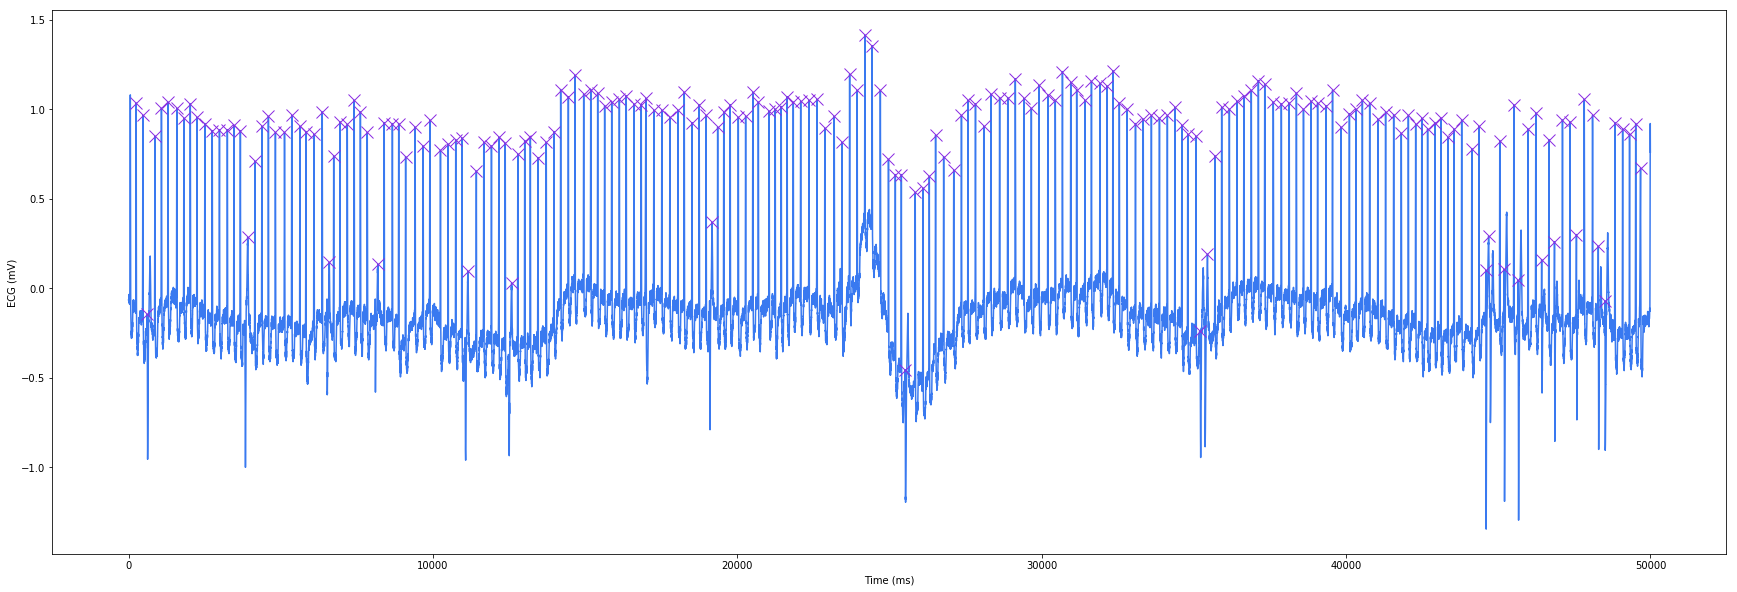

In [2]:
datanumb=31  #which data set to look at

# Use the gqrs algorithm to detect qrs locations in the first channel
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(recordall[datanumb].fs * 60 / max_bpm)
qrs_inds = processing.gqrs_detect(sig=pchannel[datanumb], fs=recordall[datanumb].fs)
peak_inds = processing.correct_peaks(pchannel[datanumb], peak_inds=qrs_inds,
                                               search_radius=search_radius, smooth_window_size=100)
hrs = processing.compute_hr(sig_len=pchannel[datanumb].shape[0], qrs_inds=peak_inds, fs=recordall[datanumb].fs) #find heart beat for later feature extraction

print('Gqrs detected peak indices:', sorted(peak_inds))

wf.plot_wfdb(record=recordall[datanumb], annotation = annall[datanumb], title='Record '+file_nums[datanumb]+' from MITBIH', plot_sym=True, time_units='seconds', figsize=(30,20))
plt.figure(figsize=(30,10))
plt.plot(pchannel[datanumb], color='#3979f0', label='Signal')
plt.plot(peak_inds, pchannel[datanumb][peak_inds], 'rx', marker='x', color='#8A2BE2', label='Peak', markersize=12)
plt.xlabel('Time (ms)')
plt.ylabel('ECG (mV)')
plt.tick_params('y')

Extracting features based on peak detection. 

[   13    57   250   471   625   866  1081  1298  1586  1818  2028  2249
  2508  2749  2987  3246  3464  3674  3841  4151  4381  4595  4825  5124
  5363  5631  5828  6092  6364  6531  6740  6947  7187  7414  7617  7842
  8115  8399  8669  8876  9103  9415  9678  9899 10247 10498 10750 10952
 11072 11427 11670 11923 12167 12376 12506 12789 13016 13201 13452 13723
 13977 14197 14449 14667 14954 15184 15413 15642 15874 16125 16352 16606
 16845 16998 17259 17521 17787 18054 18257 18513 18747 18977 19102 19355
 19555 19767 20034 20274 20510 20692 21047 21246 21444 21638 21840 22083
 22356 22618 22876 23184 23438 23691 23939 24193 24431 24700 24968 25192
 25390 25528 25846 26103 26308 26514 26779 27111 27365 27579 27826 28099
 28332 28619 28886 29135 29413 29661 29909 30205 30448 30683 30955 31150
 31423 31636 31916 32151 32340 32552 32805 33083 33338 33605 33870 34130
 34379 34606 34800 35070 35223 35373 35695 35914 36166 36419 36644 36888
 37120 37329 37611 37875 38133 38369 38602 38851 39

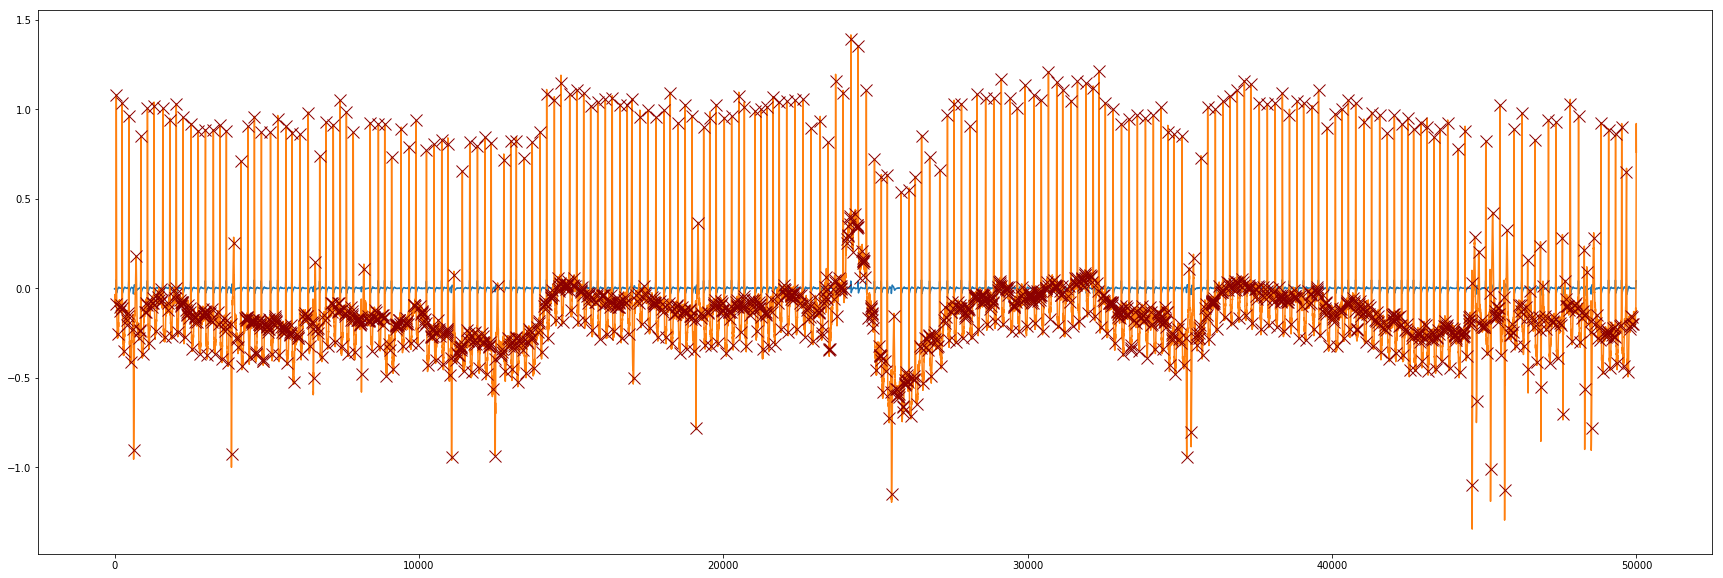

In [3]:
lowcut=.5      #low frequency cutoff for bandpass filter
highcut=4   #high frequency cutoff for bandpass filter
window=5     #window size for moving window integration3

nyquist_freq = 0.5 * record.fs #calculating the nyquist frequency using the sampling frequency
low = lowcut / nyquist_freq #lowpass filtering cutoff
high = highcut / nyquist_freq #highpass filtering cutoff
bf, af = butter(1, [low, high], btype="band")
xf = lfilter(bf, af, pchannel[datanumb]) #bandpass filtering
yf = np.ediff1d(xf) #deriving the data
fin = np.convolve(yf, np.ones(window)/window, mode='valid') #moving window average smoothing
zero_crossings = np.where(np.diff(np.sign(fin)))[0] #find the zero crossings in the differential ie minima and maxima
plt.figure(figsize=(30,10))
plt.plot(fin)
plt.plot(pchannel[datanumb])
plt.plot(zero_crossings[:-2]-3, pchannel[datanumb][zero_crossings[:-2]-3], 'rx', marker='x', color='#8b0000', label='Peak', markersize=12)
anno = [annall[datanumb].sample, annall[datanumb].symbol]
print(anno[0])
#plot data compensating for the delay introduced by the moving window
#axes = plt.gca()
#axes.set_ylim([-0.1,0.1])


Segmentation of data into time frames based on proximity to arrythmic beat. Data separated into training windows with window before arrythmic beat being the training set for prediction algorithms.

In [37]:
wr = 5 #average amount of heart beats/R peaks for a segment
ws = 3 #spacing in number of heart beats between windows

arry=[] #setting up list of arrythmic beats for learning
normalt1=[] #setting up list of normal beats for learning t-1
normalt2=[] #t-2
normalt3=[] #t-3
normalt4=[] #t-4
normalt5=[] #t-5

Nb=[] #normal beat
Lb=[] #Left bundle branch block beat
Rb=[] #Right bundle branch block beat
Bb=[] #Bundle branch block beat (unspecified)
Ab=[] #Atrial premature beat
ab=[] #Aberrated atrial premature beat
Jb=[] #Nodal (junctional) premature beat
Sb=[] #Supraventricular premature or ectopic beat (atrial or nodal)
Vb=[] #Premature ventricular contraction
rb=[] #R-on-T premature ventricular contraction
Fb=[] #Fusion of ventricular and normal beat
eb=[] #Atrial escape beat
jb=[] #Nodal (junctional) escape beat
nb=[] #Supraventricular escape beat (atrial or nodal)
Eb=[] #Ventricular escape beat
Pb=[] #Paced beat actual symbol /
fb=[] #Fusion of paced and normal beat
Qb=[] #Unclassifiable beat

abl=['L','R','B','A','a','J','S','V','r','F','e','j','n','E','P','f','Q'] #list of abnormal beats

#This first part is to test if data right before the arrythmic beat could predict the arrythmic beat. This will use raw lagged
#data as the input and the arrythmic beats themselves as the desired output. For data consistency, the data length will be
#normalized to the length of the number of heartbeats specified in wr according t othe average heart rate
hry = sum(hrs[~np.isnan(hrs)]) / len(hrs[~np.isnan(hrs)]) #average heart rate
tlen = int(recordall[datanumb].fs / (hry / 60))
#Set the total length of the segmented data to specified wr times the average heart rate

for i in range(len(annall[datanumb].symbol)):
    if annall[datanumb].symbol[i] in abl:
        try:
            arry.append(pchannel[datanumb][annall[datanumb].sample[i]-tlen:annall[datanumb].sample[i]+(wr-1)*tlen])
            #append all data arrythmic beats specified for window size
            normalt1.append(pchannel[datanumb][annall[datanumb].sample[i]-(wr+1)*tlen:annall[datanumb].sample[i]-tlen])
            normalt2.append(pchannel[datanumb][annall[datanumb].sample[i]-(wr+2)*tlen:annall[datanumb].sample[i]-2*tlen])
            normalt3.append(pchannel[datanumb][annall[datanumb].sample[i]-(wr+3)*tlen:annall[datanumb].sample[i]-3*tlen])
            normalt4.append(pchannel[datanumb][annall[datanumb].sample[i]-(wr+4)*tlen:annall[datanumb].sample[i]-4*tlen])
            normalt5.append(pchannel[datanumb][annall[datanumb].sample[i]-(wr+5)*tlen:annall[datanumb].sample[i]-5*tlen])
            #append all data right before the arrythmic beats -t-i- to increasing window sizes
        except IndexError:
            pass
        
#This second part is to either normalize peak location in order to feed into learning or to extract peak-independent features
    

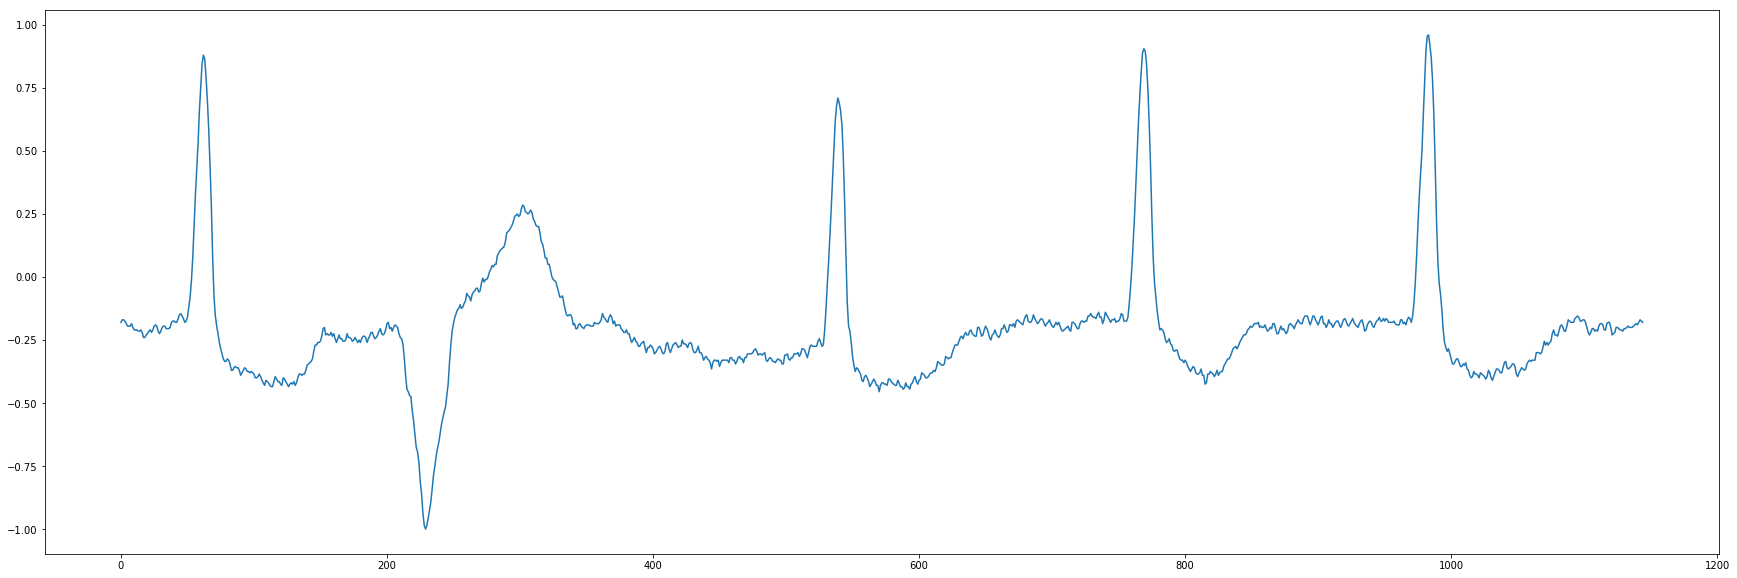

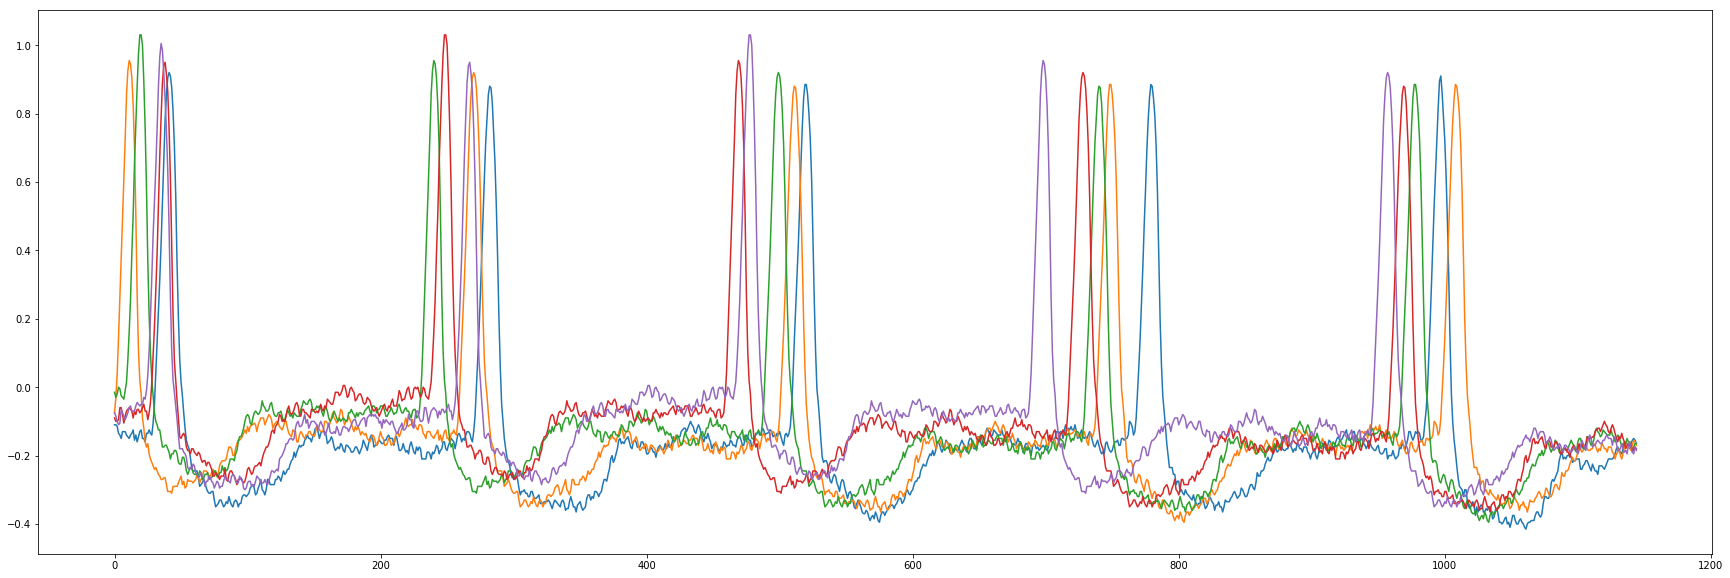

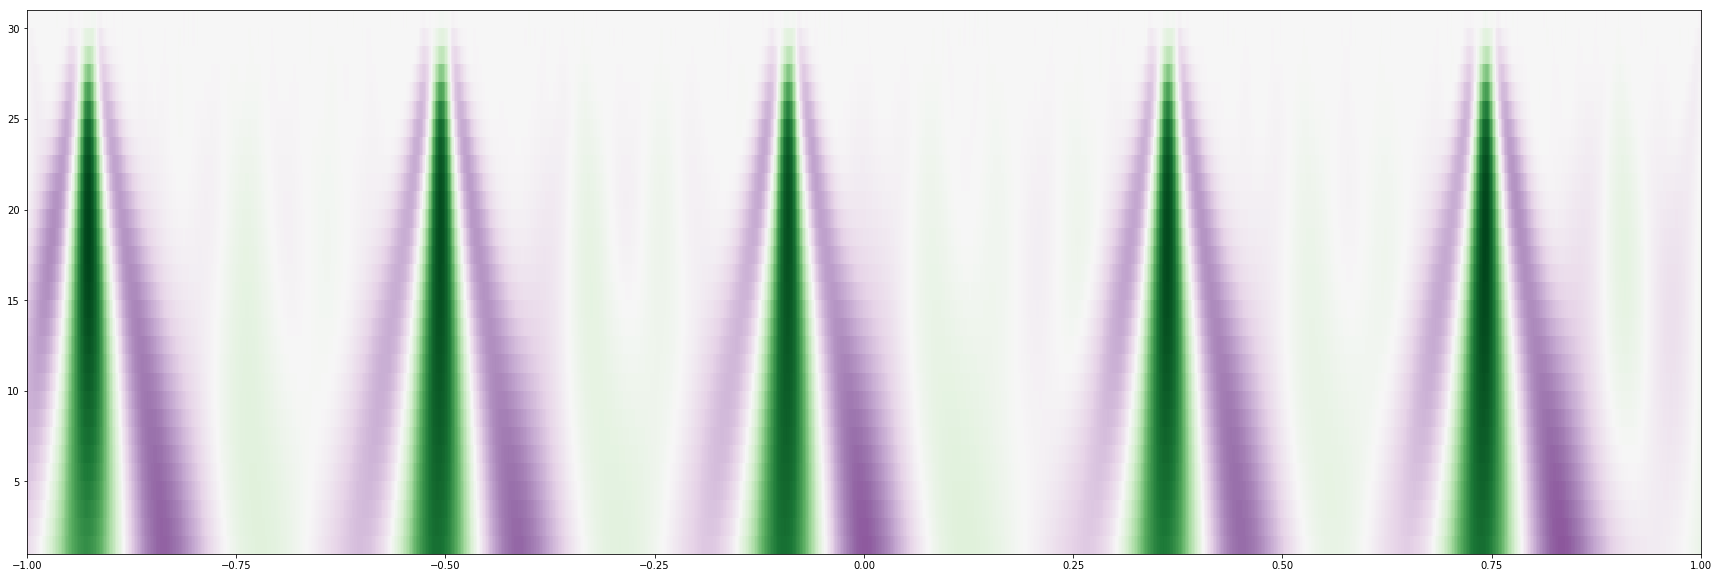

In [54]:
dat = 1
#attempts at wavelet transform: the transformation is dependent on the peak location, which hasn't been normalized
plt.figure(figsize=(30,10))
plt.plot(arry[dat])
plt.figure(figsize=(30,10))
plt.plot(normalt1[dat])
plt.plot(normalt2[dat])
plt.plot(normalt3[dat])
plt.plot(normalt4[dat])
plt.plot(normalt5[dat])
widths = np.arange(1, 31)
cwtmatr = signal.cwt(normalt1[dat], signal.ricker, widths)
plt.figure(figsize=(30,10))
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

360